**Скачиваем и подготавливаем данные**

In [ ]:
# скачиваем и распаковываем данные
!kaggle datasets download rmisra/news-headlines-dataset-for-sarcasm-detection

import zipfile

with zipfile.ZipFile('news-headlines-dataset-for-sarcasm-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 91% 3.00M/3.30M [00:00<00:00, 5.47MB/s]
100% 3.30M/3.30M [00:00<00:00, 5.05MB/s]


In [ ]:
# установим необходимые пакеты

!pip install catboost
!pip install datasets
!pip install evaluate
!pip install langdetect
!pip install pymystem3
!pip install sentence_transformers

import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from catboost import CatBoostClassifier
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, \
                         Trainer, DataCollatorWithPadding
import torch
from datasets import Dataset, DatasetDict
import evaluate
from sentence_transformers import SentenceTransformer
from langdetect import detect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=d2313e619a39de72b1a6ac2892084951ff543e411818fbc477e9fdcea7acb1d1
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
# посмотрим на данные, которые у нас есть
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [ ]:
# удалим адрес ссылки, она не нужна
df = df.drop('article_link', axis=1)

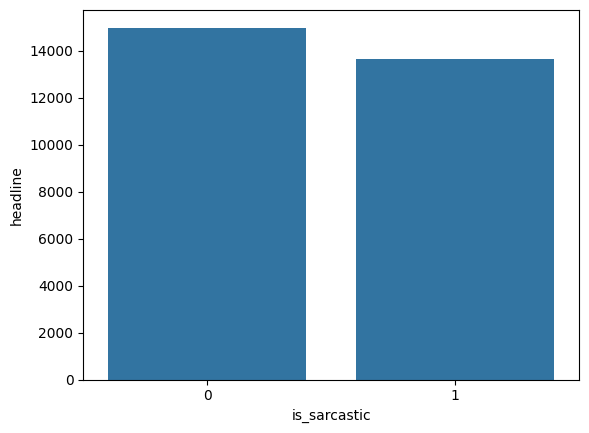

In [ ]:
sns.barplot(df.groupby('is_sarcastic').agg('count')['headline']);

как вы можем увидеть, классы довольно сбалансированны

давайте теперь почистим данные от символов для TFIDF
для языковых моделей будем использовать готовый текст

In [ ]:
df['headline_cleared'] = df['headline'].apply(lambda x: re.sub(r'[^\w\s]|[0-9]', ' ', x))

In [ ]:
df

,is_sarcastic,headline,headline_cleared
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word strea...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...,mars probe destroyed by orbiting spielberg gat...


давайте теперь посмотрим на язык текста

In [ ]:
df[df.headline.str.contains('ү')]
df['lang'] = df.headline_cleared.apply(detect)

In [ ]:
df.groupby('lang').agg('count')['headline_cleared']

,headline_cleared
lang,
af,155
ca,109
cs,3
cy,24
da,141
de,13
en,27295
es,63
et,32


In [ ]:
# удалим колонку "lang"
df = df.drop('lang', axis=1)

языки разные присутствуют, но подавляющее большинство комментариев на английском, в любом случае оставим все комментарии

данные готовы, теперь необходимо сделать разбиения на train, test, valid

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['is_sarcastic'])
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train['is_sarcastic'])

Давайте теперь будем использовать модели для предсказания

- TF-IDF + CatBoost/LogisticRegression
- sentence-transformer + Catboost
- TinyBert
- Hugging Face BERT

**1. TF-IDF + CatBoost**

Давайте сначала удалим стоп слова, а также лемматизируем наш текст

In [ ]:
nltk.download("stopwords")
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

def lemm_preprocess(text):

  tokens = mystem.lemmatize(text.lower())
  tokens = [token for token in tokens if token not in russian_stopwords and token != " " and len(token) > 1]
  text = " ".join(tokens).strip(' \n')

  return text

train['lemm'] = train['headline_cleared'].apply(lemm_preprocess)
test['lemm'] = test['headline_cleared'].apply(lemm_preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
X_train = train['lemm']
y_train = train['is_sarcastic']
X_test = test['lemm']
y_test = test['is_sarcastic']

а теперь векторизуем

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

возьмем модель CatBoost, обучим на Train и сделаем предсказание на Test

In [ ]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


# Оценка производительности модели
f1 = f1_score(y_test, y_pred, average='binary')
print(f"f1_score: {f1}")

0:	learn: 0.6678647	total: 412ms	remaining: 6m 51s
1:	learn: 0.6497758	total: 582ms	remaining: 4m 50s
2:	learn: 0.6339008	total: 779ms	remaining: 4m 18s
3:	learn: 0.6212043	total: 947ms	remaining: 3m 55s
4:	learn: 0.6114541	total: 1.12s	remaining: 3m 43s
5:	learn: 0.6009109	total: 1.28s	remaining: 3m 32s
6:	learn: 0.5931551	total: 1.46s	remaining: 3m 26s
7:	learn: 0.5858214	total: 1.63s	remaining: 3m 21s
8:	learn: 0.5800863	total: 1.81s	remaining: 3m 19s
9:	learn: 0.5744804	total: 1.97s	remaining: 3m 15s
10:	learn: 0.5707401	total: 2.14s	remaining: 3m 12s
11:	learn: 0.5664355	total: 2.3s	remaining: 3m 9s
12:	learn: 0.5635204	total: 2.47s	remaining: 3m 7s
13:	learn: 0.5597407	total: 2.63s	remaining: 3m 5s
14:	learn: 0.5565532	total: 2.81s	remaining: 3m 4s
15:	learn: 0.5538184	total: 2.98s	remaining: 3m 3s
16:	learn: 0.5514382	total: 3.15s	remaining: 3m 1s
17:	learn: 0.5492000	total: 3.31s	remaining: 3m
18:	learn: 0.5468865	total: 3.47s	remaining: 2m 59s
19:	learn: 0.5442912	total: 3.64s

возьмем модель LogisticRegression, обучим на Train и сделаем предсказание на Test

In [ ]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


# Оценка производительности модели
f1 = f1_score(y_test, y_pred, average='binary')
print(f"f1_score: {f1}")

f1_score: 0.8312816799420709


получили неплохие показатели по CatBoost f1 = 0.82, а по LogisticRegression f1 = 0.83

**2. sentence-transformer + Catboost**

In [ ]:
X_train = train['headline']
y_train = train['is_sarcastic']
X_test = test['headline']
y_test = test['is_sarcastic']

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


def preprocess(data, model):
  embed = data.apply(model.encode)
  embed = pd.DataFrame(embed.tolist(), index=data.index)
  return embed

embedded_train = preprocess(X_train, model)
embedded_test = preprocess(X_test, model)
embedded_train.sample(10)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
16633,0.204172,-0.122982,0.212576,0.212724,-0.513706,-0.095310,0.706701,0.268706,-0.247309,-0.022884,...,0.022254,-0.094363,0.226993,-0.004180,-0.524977,-0.038275,0.252573,-0.046894,-0.006034,0.401617
8681,-0.225252,-0.049556,0.224297,-0.160500,0.126138,-0.190302,0.330128,0.018999,0.022844,-0.231483,...,-0.073124,-0.087816,-0.047685,-0.011426,0.191414,-0.024267,-0.045977,-0.378351,0.086992,0.056885
27153,0.499314,0.220556,-0.030231,0.015806,0.252285,-0.094455,0.312186,0.059371,-0.210165,-0.057277,...,0.241044,-0.727678,0.150671,-0.040005,-0.316569,-0.199875,0.417357,-0.093627,-0.122604,0.158277
27433,0.416668,0.440590,-0.393501,0.250392,0.286481,0.319899,-0.423046,-0.578176,0.672043,0.155796,...,-0.124773,-0.159539,0.314022,0.378536,-0.101023,0.223951,0.540533,-0.269978,-0.218578,0.298906
23811,0.182766,-0.300165,0.075031,-0.456549,-0.014877,0.042819,-0.110205,-0.528373,0.368679,-0.056693,...,0.055947,-0.013302,0.308472,-0.304028,0.089728,0.230423,-0.421907,0.331365,0.144243,0.065442
10104,-0.262645,0.166435,-0.103592,-0.026668,-0.059175,0.323288,0.168283,-0.506315,-0.356802,-0.281853,...,0.025041,-0.090575,0.178959,0.227184,0.056806,-0.064805,0.150522,-0.011195,0.130525,0.216034
14564,0.233156,0.117785,0.089254,0.187817,0.170794,-0.131355,-0.637743,-0.429018,-0.031204,-0.038978,...,0.076453,-0.001209,0.121129,-0.012264,0.098296,-0.381149,0.197740,0.258525,0.294309,-0.073534
16220,-0.220343,0.019819,-0.087485,-0.435710,-0.140937,-0.230140,-0.311999,0.100151,-0.086294,0.126742,...,0.264366,0.273830,0.045784,-0.027968,-0.302951,0.545700,0.157026,-0.102190,0.199761,0.060394
6138,-0.048666,0.278457,-0.100238,-0.168186,0.129127,0.033601,-0.014875,-0.283014,-0.383984,-0.283159,...,-0.112693,-0.098408,-0.439210,0.267232,0.113396,0.050140,0.011317,-0.352381,0.201473,0.132875
3666,-0.299689,0.392616,-0.261600,-0.335868,-0.152180,0.074753,-0.448062,-0.188965,0.403525,0.101468,...,-0.052547,-0.018071,0.125897,0.126155,-0.172003,0.176162,0.029128,-0.198987,-0.031596,0.003311


возьмем модель CatBoost, обучим на Train и сделаем предсказание на Test

In [ ]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)
model.fit(embedded_train, y_train)
y_pred = model.predict(embedded_test)


# Оценка производительности модели
f1 = f1_score(y_test, y_pred, average='binary')
print(f"f1_score: {f1}")

0:	learn: 0.6818912	total: 143ms	remaining: 2m 22s
1:	learn: 0.6733840	total: 256ms	remaining: 2m 7s
2:	learn: 0.6665406	total: 367ms	remaining: 2m 1s
3:	learn: 0.6594714	total: 478ms	remaining: 1m 58s
4:	learn: 0.6529526	total: 591ms	remaining: 1m 57s
5:	learn: 0.6472706	total: 708ms	remaining: 1m 57s
6:	learn: 0.6422557	total: 825ms	remaining: 1m 56s
7:	learn: 0.6370814	total: 932ms	remaining: 1m 55s
8:	learn: 0.6318070	total: 1.05s	remaining: 1m 55s
9:	learn: 0.6274715	total: 1.16s	remaining: 1m 54s
10:	learn: 0.6236075	total: 1.27s	remaining: 1m 54s
11:	learn: 0.6197515	total: 1.38s	remaining: 1m 53s
12:	learn: 0.6163207	total: 1.49s	remaining: 1m 53s
13:	learn: 0.6125374	total: 1.6s	remaining: 1m 52s
14:	learn: 0.6093034	total: 1.71s	remaining: 1m 52s
15:	learn: 0.6057568	total: 1.82s	remaining: 1m 52s
16:	learn: 0.6025485	total: 1.94s	remaining: 1m 52s
17:	learn: 0.5995283	total: 2.06s	remaining: 1m 52s
18:	learn: 0.5963408	total: 2.17s	remaining: 1m 52s
19:	learn: 0.5940989	tota

f1=0,78, что хуже чем в предыдущем методе

далее нам необходимо провести дополнительную предобработку для более сложных (дальнейших) методов

In [ ]:
df_train = train[['headline', 'is_sarcastic']].rename(columns={'headline': 'text', 'is_sarcastic': 'labels'})
df_valid = valid[['headline', 'is_sarcastic']].rename(columns={'headline': 'text', 'is_sarcastic': 'labels'})
df_test = test[['headline', 'is_sarcastic']].rename(columns={'headline': 'text', 'is_sarcastic': 'labels'})

# Преобразуем pandas DataFrame в Dataset
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)
test_dataset = Dataset.from_pandas(df_test)

также надо прописать функцию метрики f1

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Функция для вычисления метрик
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1
    }


**3. TinyBERT**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Загружаем модель
model_name = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./cache")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, cache_dir="./cache")

# Функция токенизации
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Применяем функцию токенизацию к данным
train_dataset_tb = train_dataset.map(tokenize_function, batched=True)
valid_dataset_tb = valid_dataset.map(tokenize_function, batched=True)
test_dataset_tb = test_dataset.map(tokenize_function, batched=True)

# Убираем колонку "text"
train_dataset_tb = train_dataset_tb.remove_columns(["text"])
valid_dataset_tb = valid_dataset_tb.remove_columns(["text"])
test_dataset_tb = test_dataset_tb.remove_columns(["text"])

# Устанавливаем параметры обучения
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    bf16=True
)

# Создаем тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tb,
    eval_dataset=valid_dataset_tb,
    compute_metrics=compute_metrics
)

# Начинаем обучение
trainer.train()


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/18316 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Map:   0%|          | 0/4579 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: antonsivtsev13 (antonsivtsev13-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.451700,0.322103,0.864818,0.864462
2,0.314700,0.269529,0.888185,0.881427
3,0.267500,0.262187,0.888185,0.883265


TrainOutput(global_step=1719, training_loss=0.33257538693945654, metrics={'train_runtime': 237.2176, 'train_samples_per_second': 231.635, 'train_steps_per_second': 7.247, 'total_flos': 196974791129088.0, 'train_loss': 0.33257538693945654, 'epoch': 3.0})

In [ ]:
# Оценивам модель на тестовых данных
results = trainer.evaluate(test_dataset_tb)

print(results)


{'eval_loss': 0.2831237316131592, 'eval_accuracy': 0.8819007686932215, 'eval_f1': 0.8749074759437454, 'eval_runtime': 7.9737, 'eval_samples_per_second': 717.862, 'eval_steps_per_second': 22.449, 'epoch': 3.0}


получаем показатель f1 = 0.88, что намного лучше чем при использовании других методов!

In [ ]:
# Создадим папку для модели
save_path = "sarcasm_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('sarcasm_model/tokenizer_config.json',
 'sarcasm_model/special_tokens_map.json',
 'sarcasm_model/vocab.txt',
 'sarcasm_model/added_tokens.json',
 'sarcasm_model/tokenizer.json')

In [ ]:
# Сохраняем модель на компьютер
import shutil
shutil.make_archive("sarcasm_model", "zip", "sarcasm_model")

from google.colab import files
files.download("sarcasm_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**4. Hugging Face BERT**

In [ ]:
from transformers import AutoTokenizer

# загружаем модель
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Функция токенизации
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(set(df_test["labels"]))
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset_hfb = train_dataset.map(tokenize_function, batched=True)
valid_dataset_hfb = valid_dataset.map(tokenize_function, batched=True)
test_dataset_hfb = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/18316 [00:00<?, ? examples/s]

Map:   0%|          | 0/4579 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer
import torch

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_hfb,
    eval_dataset=valid_dataset_hfb,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: antonsivtsev13 (antonsivtsev13-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.295200,0.236187,0.925311,0.920056
2,0.138500,0.262329,0.934702,0.930610
3,0.030200,0.384491,0.935794,0.931405


TrainOutput(global_step=6870, training_loss=0.18027075957696684, metrics={'train_runtime': 5597.697, 'train_samples_per_second': 9.816, 'train_steps_per_second': 1.227, 'total_flos': 1.445742626992128e+16, 'train_loss': 0.18027075957696684, 'epoch': 3.0})

In [ ]:
# Создадим папку для модели
save_path = "sarcasm_model_Hugging_Face_BERT"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('sarcasm_model_Hugging_Face_BERT/tokenizer_config.json',
 'sarcasm_model_Hugging_Face_BERT/special_tokens_map.json',
 'sarcasm_model_Hugging_Face_BERT/vocab.txt',
 'sarcasm_model_Hugging_Face_BERT/added_tokens.json',
 'sarcasm_model_Hugging_Face_BERT/tokenizer.json')

In [ ]:
# Сохраняем модель на компьютер
import shutil
shutil.make_archive("sarcasm_model_Hugging_Face_BERT", "zip", "sarcasm_model_Hugging_Face_BERT")

from google.colab import files
files.download("sarcasm_model_Hugging_Face_BERT.zip")

**лучшей моделью становится - Hugging Face BERT, c f1 = 0.93**